**Connect to ChEMBL database**
*   First, the ChEMBL web resource client as well as other Python libraries are imported.



In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

In [2]:
!pip install "numpy==1.26.4" "pandas==2.1.4"
!pip install rdkit-pypi
#!pip install rdkit-pypi
import numpy as np
import pandas as pd

In [3]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

In [4]:
!pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.2 MB/s eta 0:00:00


In [5]:
from chembl_webresource_client.new_client import new_client

In [6]:
HERE = Path(_dh[-1])
DATA = HERE / 'data'

In [7]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [8]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

**Get target data (EGFR kinase)**


*   Get UniProt ID of the target of interest (EGFR kinase: P00533) from UniProt website
*   Use UniProt ID to get target information
*   Select a different UniProt ID, if you are interested in another target.

In [26]:
#uniprot_id = "P00533"
#uniprot_id = "W8T1G8"
uniprot_id = "V5TFZ2"

In [27]:
# Fetch target data from ChEMBL
targets = targets_api.get(target_components__accession=uniprot_id).only(['target_chembl_id', 'organism', 'pref_name', 'target_type'])
# Get target information from ChEMBL but restrict it to specified values only


In [28]:
print (f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [29]:
# Download target data from ChEMBL
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Dengue virus,Nonstructural protein 5,CHEMBL4295629,SINGLE PROTEIN
1,Dengue virus,Nonstructural protein 5,CHEMBL4295629,SINGLE PROTEIN


**Select target (target ChEMBL ID)**

*   After checking the entries, we select the first entry as our target of interest:
*   CHEMBL203: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1)





In [30]:
# Select target (target ChEMBL ID)
target = targets.iloc[0]   # fetch zero (0) row from the dataframe
target

,0
organism,Dengue virus
pref_name,Nonstructural protein 5
target_chembl_id,CHEMBL4295629
target_type,SINGLE PROTEIN


**Get bioactivity data**
*   Now, we want to query bioactivity data for the target of interest.

**Fetch bioactivity data for the target from ChEMBL**
*   In this step, we fetch the bioactivity data and filter it to only consider

---



*   human proteins,
*   bioactivity type IC50,
*   exact measurements (relation '='), and
*   binding data (assay type 'B').



In [31]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL4295629


In [32]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 80, <class 'chembl_webresource_client.query_set.QuerySet'>


In [33]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 18297472,
 'assay_chembl_id': 'CHEMBL4123978',
 'assay_description': 'Inhibition of Dengue virus 4 NS5 full length RdRp activity using RNA as template assessed as inhibition of NTPs incorporation after 90 mins by FAPA assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL4126343',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '340.0',
 'target_chembl_id': 'CHEMBL4295629',
 'target_organism': 'Dengue virus',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.34'}

In [34]:
# Download bioactivity data from ChEMBL
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (80, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,18297472,CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,CHEMBL4126343,=,nM,340.0,CHEMBL4295629,Dengue virus,IC50,uM,0.34
1,18297475,CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,CHEMBL3417270,=,nM,360.0,CHEMBL4295629,Dengue virus,IC50,uM,0.36
2,18297488,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL521487,=,nM,5000.0,CHEMBL4295629,Dengue virus,IC50,uM,5.0
3,18297489,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127092,=,nM,1600.0,CHEMBL4295629,Dengue virus,IC50,uM,1.6
4,18297490,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127819,=,nM,2000.0,CHEMBL4295629,Dengue virus,IC50,uM,2.0


In [35]:
bioactivities_df["units"].unique()

array(['uM'], dtype=object)

In [36]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,18297472,CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,CHEMBL4126343,=,nM,340.0,CHEMBL4295629,Dengue virus,IC50
1,18297475,CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,CHEMBL3417270,=,nM,360.0,CHEMBL4295629,Dengue virus,IC50
2,18297488,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL521487,=,nM,5000.0,CHEMBL4295629,Dengue virus,IC50
3,18297489,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127092,=,nM,1600.0,CHEMBL4295629,Dengue virus,IC50
4,18297490,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127819,=,nM,2000.0,CHEMBL4295629,Dengue virus,IC50


**Preprocess and filter bioactivity data**

*   Convert standard_value’s datatype from object to float
*   Delete entries with missing values
*   Keep only entries with standard_unit == nM
*   Delete duplicate molecules
*   Reset DataFrame index
*   Rename columns

In [37]:
# Convert datatype of “standard_value” from “object” to “float”
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,object
target_chembl_id,object
target_organism,object


In [38]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,float64
target_chembl_id,object
target_organism,object


In [39]:
# Delete entries with missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (80, 11)


In [40]:
# Keep only entries with “standard_unit == nM”
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [41]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [42]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (80, 11)


In [43]:
# Delete duplicate molecules
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (73, 11)


In [44]:
# Reset “DataFrame” index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,18297472,CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,CHEMBL4126343,=,nM,340.0,CHEMBL4295629,Dengue virus,IC50
1,18297475,CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,CHEMBL3417270,=,nM,360.0,CHEMBL4295629,Dengue virus,IC50
2,18297488,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL521487,=,nM,5000.0,CHEMBL4295629,Dengue virus,IC50
3,18297489,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127092,=,nM,1600.0,CHEMBL4295629,Dengue virus,IC50
4,18297490,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127819,=,nM,2000.0,CHEMBL4295629,Dengue virus,IC50


In [45]:
# Rename columns --> standard_value to IC50 and standard_units to units
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,18297472,CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,CHEMBL4126343,=,nM,340.0,CHEMBL4295629,Dengue virus,IC50
1,18297475,CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,CHEMBL3417270,=,nM,360.0,CHEMBL4295629,Dengue virus,IC50
2,18297488,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL521487,=,nM,5000.0,CHEMBL4295629,Dengue virus,IC50
3,18297489,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127092,=,nM,1600.0,CHEMBL4295629,Dengue virus,IC50
4,18297490,CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,CHEMBL4127819,=,nM,2000.0,CHEMBL4295629,Dengue virus,IC50


In [46]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (73, 11)


In [47]:
# Fetch compound data from ChEMBL
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [48]:
compounds = list(tqdm(compounds_provider))  #Download compound data from ChEMBL

  0%|          | 0/73 [00:00<?, ?it/s]

In [49]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (73, 2)


In [50]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL269277,{'canonical_smiles': 'C=C(C)[C@@H]1CC[C@]2(C(=...
1,CHEMBL418052,{'canonical_smiles': 'Nc1ncnc2c1ncn2[C@@H]1O[C...
2,CHEMBL63677,{'canonical_smiles': 'O=c1cc(-c2ccc(O)c(-c3c(O...
3,CHEMBL291426,{'canonical_smiles': 'O=c1cc(-c2ccc(Oc3c(O)cc4...
4,CHEMBL73188,{'canonical_smiles': 'CC(=O)N[C@@H](C(=O)O)C(C...


In [51]:
# Remove entries with missing molecule structure entry
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (73, 2)


In [52]:
# Delete duplicate molecules
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (73, 2)


In [53]:
# Get molecules with canonical SMILES
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [54]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (73, 2)


In [55]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (73, 2)


In [57]:
# Summary of compound and bioactivity data
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 73


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [58]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 73


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**Merge both datasets**

---


Merge values of interest from bioactivities_df and compounds_df in an output_df
based on the compounds’ ChEMBL IDs (molecule_chembl_id), keeping the following columns:
---
* ChEMBL IDs: molecule_chembl_id
* SMILES: smiles
* units: units
* IC50: IC50

In [59]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 73 entries.


In [60]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [61]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL4126343,340.0,nM,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...
1,CHEMBL3417270,360.0,nM,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...
2,CHEMBL521487,5000.0,nM,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...
3,CHEMBL4127092,1600.0,nM,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...
4,CHEMBL4127819,2000.0,nM,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...
5,CHEMBL486231,18000.0,nM,C[C@@]1(F)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...
6,CHEMBL4127921,15900.0,nM,C#C[C@@]1(F)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...
7,CHEMBL4127030,6600.0,nM,C[C@]1(O)[C@H](n2ccc(=O)[nH]c2=O)O[C@](F)(COP(...
8,CHEMBL4125966,650.0,nM,C#C[C@]1(O)[C@H](n2ccc(=O)[nH]c2=O)O[C@](F)(CO...
9,CHEMBL4127565,2800.0,nM,CC#C[C@]1(O)[C@H](n2ccc(=O)[nH]c2=O)O[C@](F)(C...


In [62]:
# Add pIC50 values
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [63]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [64]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL4126343,340.0,nM,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,6.468521
1,CHEMBL3417270,360.0,nM,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,6.443697
2,CHEMBL521487,5000.0,nM,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5.301030
3,CHEMBL4127092,1600.0,nM,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,5.795880
4,CHEMBL4127819,2000.0,nM,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,5.698970


**Draw compound data**
*   Let’s have a look at our collected data set.
*   First, we plot the pIC50 value distribution

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

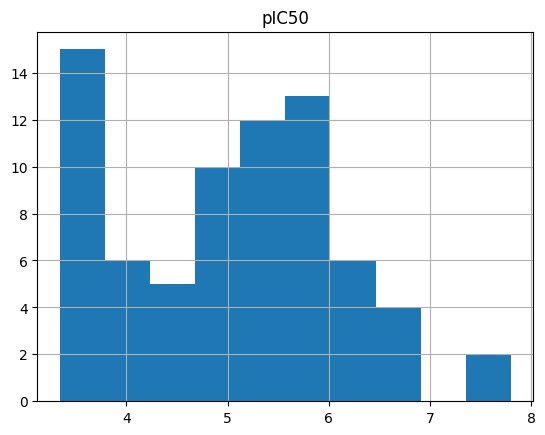

In [65]:
output_df.hist(column="pIC50")

In [66]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [67]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [68]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL4282493,16.0,nM,7.795880,<rdkit.Chem.rdchem.Mol object at 0x7e40c6a3e810>
1,CHEMBL1214186,41.0,nM,7.387216,<rdkit.Chem.rdchem.Mol object at 0x7e40c6a3fca0>
2,CHEMBL450522,160.0,nM,6.795880,<rdkit.Chem.rdchem.Mol object at 0x7e40c6a3fdf0>


In [69]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (73, 5)


In [71]:
output_df.to_csv("/content/Denv-2_NS5/NS5_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL4282493,16.0,nM,COc1cc(C)c(C(=O)NS(=O)(=O)c2cccc3cccnc23)cc1-c...,7.795880
1,CHEMBL1214186,41.0,nM,Nc1ncnc2c1ncn2[C@@H]1O[C@H](C[C@@H](N)CC[C@H](...,7.387216
2,CHEMBL450522,160.0,nM,COc1cc(O)c2c(=O)cc(-c3ccc(O)cc3)oc2c1-c1cc(-c2...,6.795880
3,CHEMBL291426,260.0,nM,O=c1cc(-c2ccc(Oc3c(O)cc4oc(-c5ccc(O)cc5)cc(=O)...,6.585027
4,CHEMBL63677,330.0,nM,O=c1cc(-c2ccc(O)c(-c3c(O)cc4oc(-c5ccc(O)cc5)cc...,6.481486


In [72]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (73, 5)
